In [1]:
import numpy as np
import matplotlib.pylab as plt
from copy import copy as cp
import matplotlib.patches as patches
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity

In [2]:
%matplotlib notebook

### Aesthetics ... function to fill in the box with a given constant value

In [3]:
def fillin(un,ixbox,iybox,overrideflag=0,overrideval=0):
    border = cp(un[ixbox.start-1,iybox.start])
    if(overrideflag == 1):
        border = overrideval
    un[ixbox,iybox] = border
    return un

### D interpolator
The coefficients m and b below are based on a fit of data from https://www.engineeringtoolbox.com/air-diffusion-coefficient-gas-mixture-temperature-d_2010.html.

In [4]:
def getDofT(T):
    """ This produces D in micrometers^2/microsecond """
    """ Assumes temperature in degrees K """

    m = 1.86121271
    b = -7.35421981
    logD = m*np.log(T.magnitude)+b
    D = np.exp(logD)
    D = AssignQuantity(D,'micrometers^2/microsecond')
    return D

def getDofTpow(T):
    """ This produces D in micrometers^2/microsecond """
    """ Assumes temperature in degrees K """

    m = 1.86121271
    b = -7.35421981
    T0 = 273
    D0 = np.exp(b)*T0**m; print('D0 = ', D0)
    D = (T.magnitude/T0)**m * D0
    D = AssignQuantity(D,'micrometers^2/microsecond')
    return D

def getDofTP(T,P):
    DofT = getDofTpow(T); # print(DofT)
    P0 = AssignQuantity(1,'atm') 
    D = DofT/(P.to('atm')/P0)
    return D

### The differential equation solver

In [5]:
def propagate(u0_orig,ixbox,iybox,udirichlet,deltax_over_dx,deltay_over_dy,Dxeff,Dyeff):
    
    # Diffusion
    u0 = cp(u0_orig)
    un = cp(u0_orig)
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Dxeff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Dyeff )

    # Dirichlet outer boundary
    un[[0,-1],:]=udirichlet
    un[:,[0,-1]]=udirichlet
        
    # Pull out the stop and start indices
    ixmin = ixbox.start
    ixmax = ixbox.stop-1
    iymin = iybox.start
    iymax = iybox.stop-1

    # Inner boundary: diffusion and Neumann
    un[ixmin-1,iybox] = u0[ixmin-1,iybox] +(u0[ixmin-2,iybox] - u0[ixmin-1,iybox])*Dxeff -deltax_over_dx*u0[ixmin-1,iybox]
    un[ixmax+1,iybox] = u0[ixmax+1,iybox] +(u0[ixmax+2,iybox] - u0[ixmax+1,iybox])*Dxeff -deltax_over_dx*u0[ixmax+1,iybox]

    un[ixbox,iymin-1] = u0[ixbox,iymin-1] +(u0[ixbox,iymin-2] - u0[ixbox,iymin-1])*Dyeff -deltay_over_dy*un[ixbox,iymin-1]
    un[ixbox,iymax+1] = u0[ixbox,iymax+1] +(u0[ixbox,iymax+2] - u0[ixbox,iymax+1])*Dyeff -deltay_over_dy*un[ixbox,iymax+1]
        
    return un

### Laying out the simulation space

In [6]:
nx = 353
ny = 353
xmax = AssignQuantity(1000,'micrometer')
ymax = AssignQuantity(1000,'micrometer')

x = np.linspace(0,xmax,nx); dx = x[1]-x[0]; print('dx', dx)
y = np.linspace(0,ymax,ny); dy = y[1]-y[0]; print('dy',dy)
dx2 = dx**2
dy2 = dy**2
nxmid = int(nx/2); # print('nxmid =', nxmid); # print('x(nxmid) =',x[nxmid])
nymid = int(ny/2)
x = x-x[nxmid]
y = y-y[nymid]

dx 2.840909090909091 micrometer
dy 2.840909090909091 micrometer


### Diffusion coefficient
See https://acp.copernicus.org/articles/20/12569/2020/#&gid=1&pid=1 for cirrus cloud conditions

In [7]:
# Compute diffusion coefficient of water through air at this temperature (lost the source on this)
Dcalculation = 'SEM'

if Dcalculation == 'SEM':
    Temp = AssignQuantity(240,'kelvin')
#     Pressure = AssignQuantity(50,'pascal'); Pressure.ito('atm') # SEM pressure
    Pressure = AssignQuantity(80,'pascal'); Pressure.ito('atm') # SEM pressure
elif Dcalculation == 'cirrus':
    Temp = AssignQuantity(240,'kelvin')
    Pressure = AssignQuantity(400,'hectopascal') # simulating air at an altitude like that of a cirrus cloud
else:
    Temp = AssignQuantity(273,'kelvin')
    Pressure = AssignQuantity(1,'atm')

print('Pressure = ', Pressure)


# This is using trends from engineering toolbox, with the log-log correction
D = getDofTP(Temp,Pressure); print('loglog method says D = ', D)

dt = (dx2+dy2)/D/10; print('dt = ', dt)
Dxeff = D*dt/dx2; print('Dxeff = ', Dxeff)
Dyeff = D*dt/dy2; print('Dyeff = ', Dyeff)

Pressure =  0.0007895386133728102 standard_atmosphere
D0 =  21.893732126411837
loglog method says D =  21817.699649146805 micrometer ** 2 / microsecond
dt =  7.398364257091172e-05 microsecond
Dxeff =  0.19999999999999998 dimensionless
Dyeff =  0.19999999999999998 dimensionless


### Working on the Neumann boundary condition

In [8]:
P3 = AssignQuantity(611,'Pa')
R = AssignQuantity(8.314,'J/mol/K')
T3 = AssignQuantity(273,'kelvin')

Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Vapor pressure at this temperature = ', P_vapor_eq)

density_ice = AssignQuantity(1,'g/cm^3')
molarmass_ice = AssignQuantity(18,'g/mol')
kappa = P_vapor_eq/(R*T3)/(density_ice/molarmass_ice)
kappa.ito('dimensionless')
print('kappa = ', kappa)

# This value comes from the CM
g_ice = AssignQuantity(2,'micrometer/second')

# Converting that to g(vapor)
g_vap = g_ice/kappa
print('g_vap = ', g_vap)

deltax = g_vap*dt
deltax.ito('micrometer')
deltay = deltax
print('distance of vapor consumed each time step = ', deltax)
deltax_over_dx = deltax/dx
print('deltax_over_dx (%) = ', deltax_over_dx*100)
deltay_over_dy = deltay/dy
print('deltay_over_dy (%) = ', deltay_over_dy*100)

Vapor pressure at this temperature =  29.55023347583504 pascal
kappa =  2.3434773182135555e-07 dimensionless
g_vap =  8534326.252940267 micrometer / second
distance of vapor consumed each time step =  0.000631400543081081 micrometer
deltax_over_dx (%) =  0.022225299116454055 dimensionless
deltay_over_dy (%) =  0.022225299116454055 dimensionless


In [9]:
# This is the far-field boundary
sigma0 = 0.2

# sigmaII_far_field = 0.1762 # This produces sigmaI = 0.22 at L=50 um, when pressure = 0.1 atm and T=273 (I think)
sigmaII_far_field = 0.0355 # This produces sigmaI = 0.2205 at L=50 um, when pressure = 50 pa and T=240
sigmaII_far_field = 0.0354 # This produces sigmaI = 0.22 at L=50 um, when pressure = 50 pa and T=240

sigmaI_far_field = sigmaII_far_field + sigma0

print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)
udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

sigmaI_far_field =  0.2354
sigmaII_far_field =  0.0354
udirichlet =  36.50635843604661 pascal


In [10]:
# # This restarts the array accumulation
Lx_list = np.array([])
Ly_list = np.array([])
uslicex_list = np.array([])
uslicey_list = np.array([])
c_rx_list = np.array([])
c_ry_list = np.array([])

# Looping
# Ldesired_list = AssignQuantity(np.arange(20,90,20),'micrometer')
# Ldesired_list = AssignQuantity(np.arange(20,90,5),'micrometer')
# Ldesired_list = AssignQuantity(np.arange(50,51,1),'micrometer')
Ldesired_list = AssignQuantity(np.arange(100,101,1),'micrometer')
# Ldesired_list = AssignQuantity(np.arange(46,55,2),'micrometer')
aspect_ratio = 1
ntimes = 20000
print('Integrating out to ', ntimes*dt)


for Ldesired in Ldesired_list:
    
    # Define the box inside
    Ldesiredx = Ldesired # Doesn't always work out to this because the grid is discretized
    boxradx = int(Ldesiredx/dx)
    Lx = boxradx*dx; 
    
    Ldesiredy = Ldesiredx*aspect_ratio
    boxrady = int(Ldesiredy/dy)
    Ly = boxrady*dy; 

    ixboxmin = nxmid-boxradx
    ixboxmax = nxmid+boxradx
    iyboxmin = nymid-boxrady
    iyboxmax = nymid+boxrady

    # Setting up to slice through the volume
    ixbox = slice(ixboxmin,ixboxmax); # print(ixbox)
    iybox = slice(iyboxmin,iyboxmax); # print(iybox)

    # Initialize u0 and un as ones/zeros matrices 
    u0 = np.ones([nx, ny])*udirichlet # old u values

    # Initialize the state of the vapor field
    un = cp(u0)

    # Propagate forward a bunch of times
    for i in range(ntimes):
        un = propagate(un,ixbox,iybox,udirichlet,deltax_over_dx,deltay_over_dy,Dxeff,Dyeff)

    # Now a slice just across one of the box surfaces (in the x dimension)
    uslicex = un[ixbox,nymid+boxrady]
    c_rx = (max(uslicex)-min(uslicex))/uslicex[0]*100

    # Now a slice just across one of the box surfaces (in the Y dimension)
    uslicey = un[nxmid+boxradx, iybox]
    c_ry = (max(uslicey)-min(uslicey))/uslicey[0]*100

    # Accumulate
    Lx_list = np.append(Lx_list,Lx)
    Ly_list = np.append(Ly_list,Ly)
    uslicex_list = np.append(uslicex_list,uslicex[0])
    uslicey_list = np.append(uslicey_list,uslicey[0])
    c_rx_list = np.append(c_rx_list,c_rx)
    c_ry_list = np.append(c_ry_list,c_ry)
    
    # Reporting
    print('Done with Lxdesired, Lx = ', Ldesired, Lx)

Integrating out to  1.4796728514182345 microsecond
Done with Lxdesired, Lx =  100 micrometer 99.43181818181817 micrometer


dt, tmax =  7.398364257091172e-05 microsecond 1.4796728514182345 microsecond


<IPython.core.display.Javascript object>


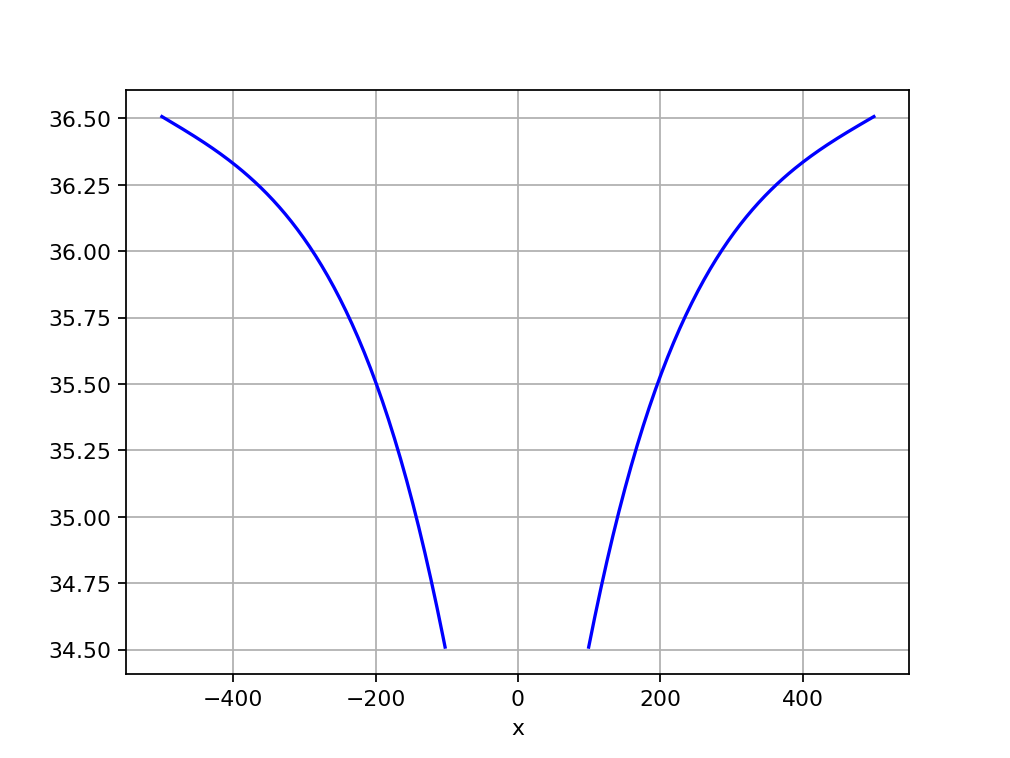

/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


<IPython.core.display.Javascript object>


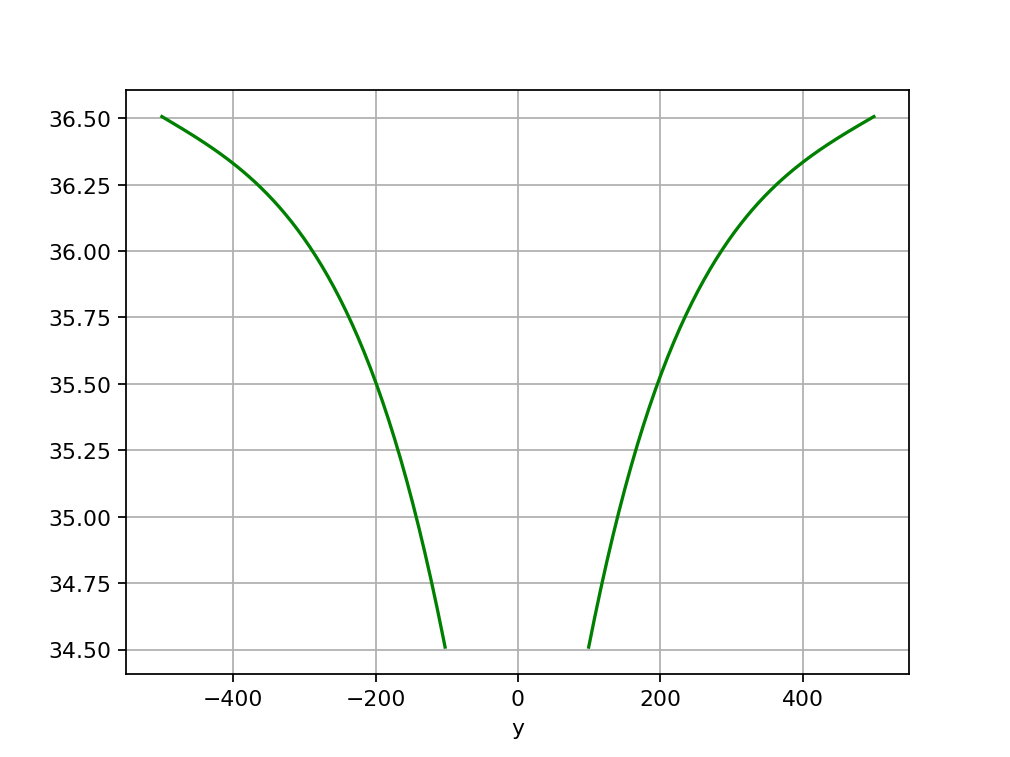

<IPython.core.display.Javascript object>


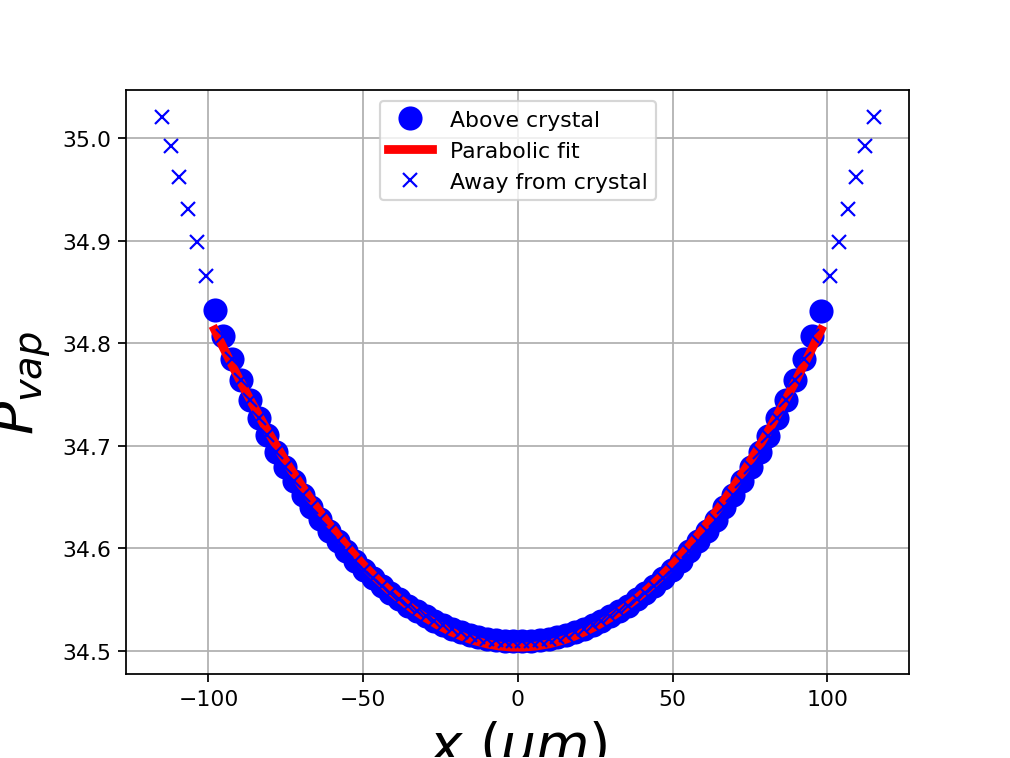

<IPython.core.display.Javascript object>


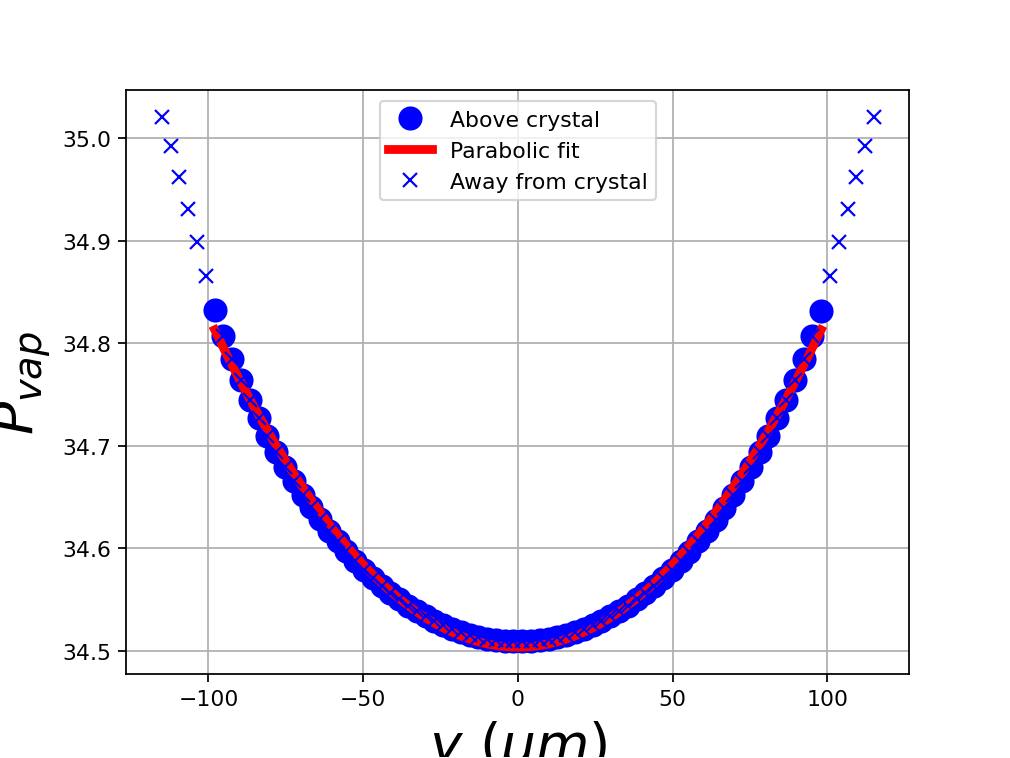

<IPython.core.display.Javascript object>


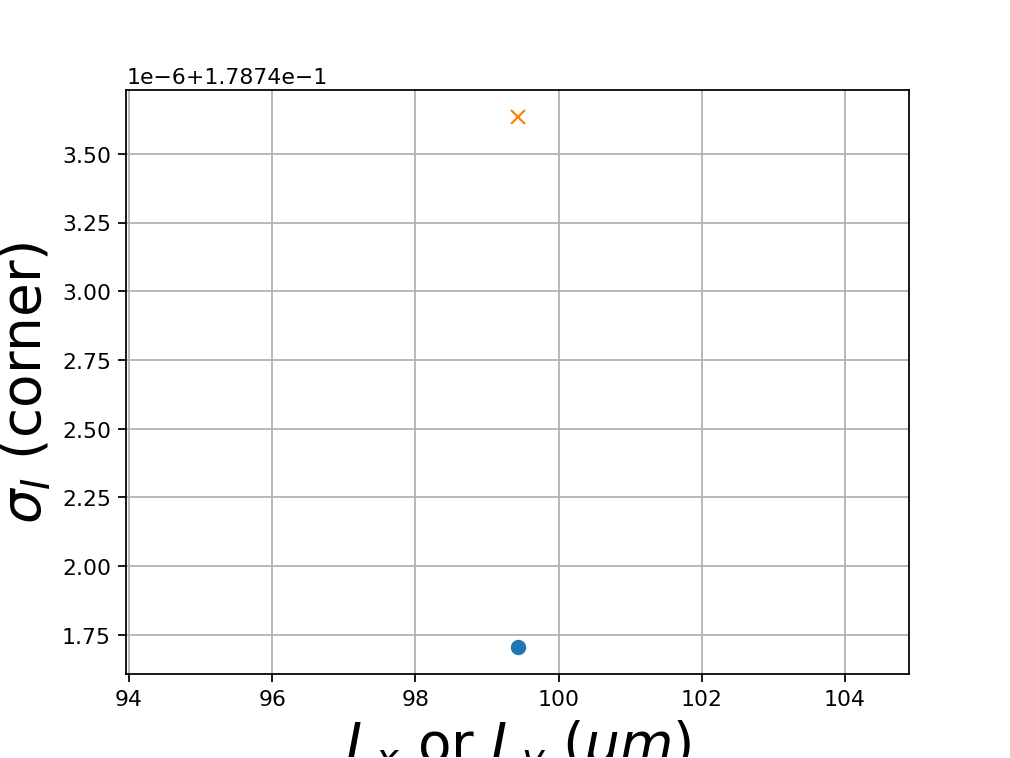

<IPython.core.display.Javascript object>


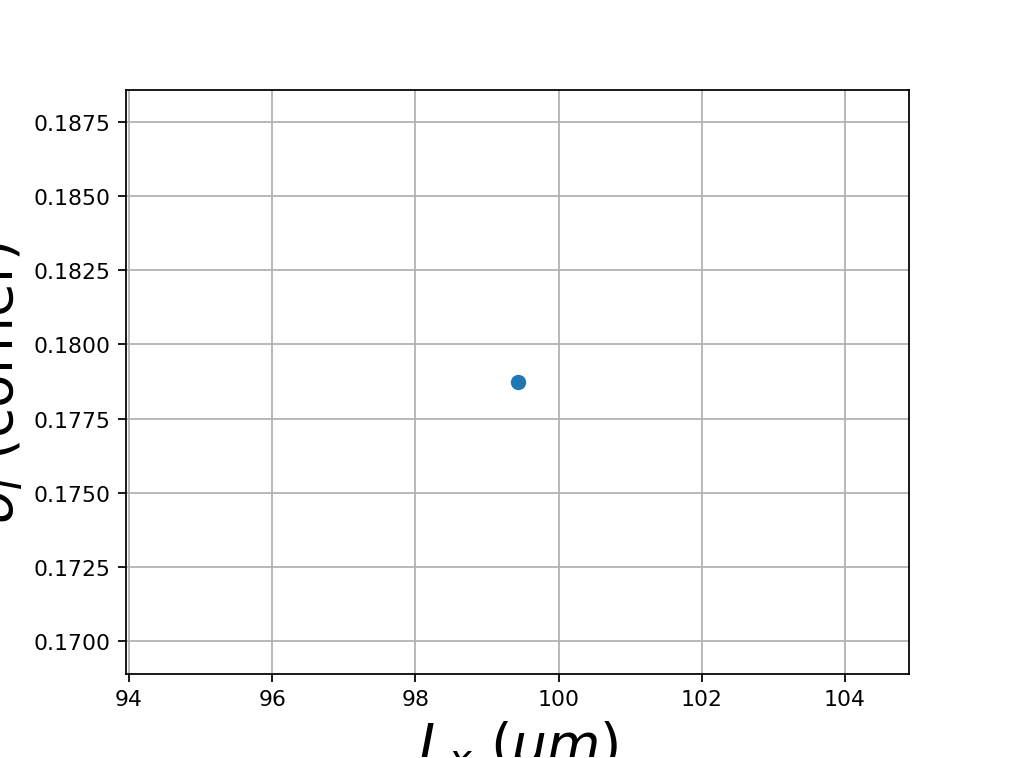

<IPython.core.display.Javascript object>


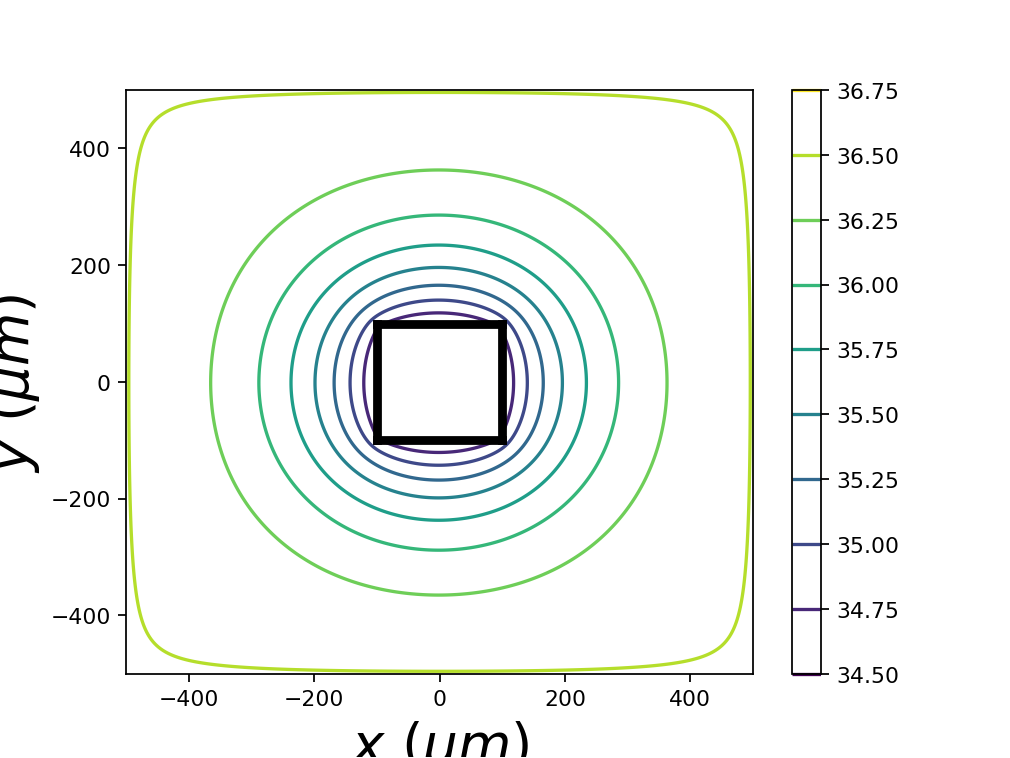

/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/contour.py:1470: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x, dtype=np.float64)
/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/contour.py:1471: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y, dtype=np.float64)
/Users/nesh/anaconda3/lib/python3.10/site-packages/numpy/ma/core.py:2820: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


<IPython.core.display.Javascript object>


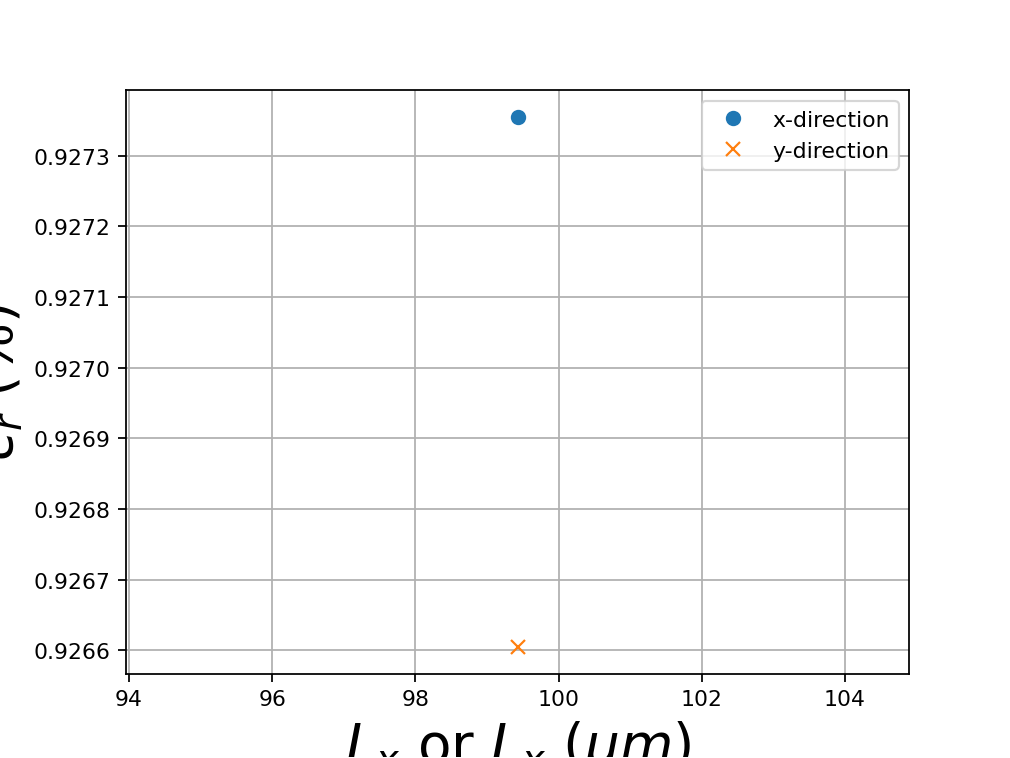

<IPython.core.display.Javascript object>


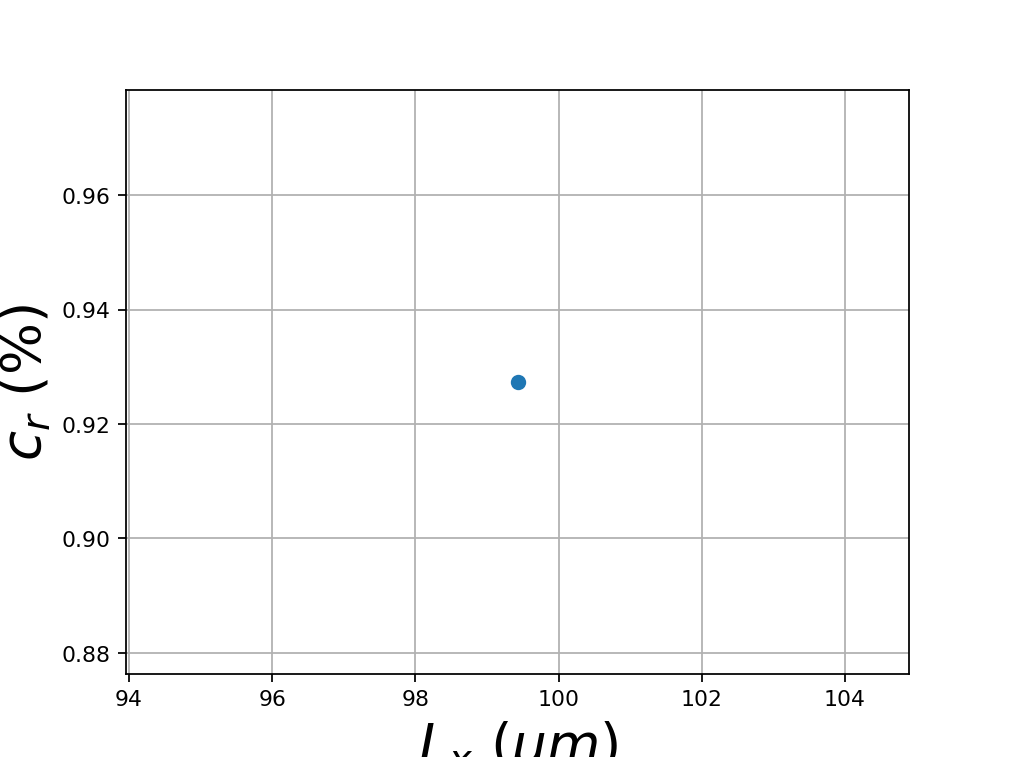

In [11]:
# Time reporting
print('dt, tmax = ',dt, dt*ntimes)

# Filling in where the crystal is
fillin(un,ixbox,iybox)

# Plotting from far afield up to the box
iextend = 6
fontsize = 25
color = 'k'
linewidth = 4
markersize = 10

ixbox_pre = slice(0,ixboxmin)
ixbox_post = slice(ixboxmax,nx)
plt.figure()
plt.plot(x[ixbox_pre], un[ixbox_pre,nymid], 'blue')
plt.plot(x[ixbox_post],un[ixbox_post,nymid],'blue')
plt.xlabel('x')
plt.grid(True)

iybox_pre = slice(0,iyboxmin)
iybox_post = slice(iyboxmax,ny)
plt.figure()
plt.plot(y[iybox_pre], un[nxmid,iybox_pre], 'green')
plt.plot(y[iybox_post],un[nxmid,iybox_post],'green')
plt.xlabel('y')
plt.grid(True)

# This is right above the surface in the x-direction
plt.figure()
xshifted = x[ixbox]-x[nxmid]+dx/2
plt.plot(xshifted,uslicex,'ob',label='Above crystal',lw=linewidth,ms=markersize)
p = np.polyfit(xshifted.magnitude,uslicex.magnitude,2); #print(p)
xshifted_theory = np.linspace(min(xshifted),max(xshifted))
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory.magnitude),'-r',label='Parabolic fit',lw=linewidth)
bigixbox = [ix for ix in range(nxmid-boxradx-iextend,nxmid+boxradx+iextend)]
biguslice = un[bigixbox,nymid+boxrady]
bigxshifted = x[bigixbox]-x[nxmid]+dx/2
plt.plot(bigxshifted,biguslice,'xb', label='Away from crystal',lw=linewidth)
plt.xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
plt.ylabel(r'$P_{vap}$',fontsize=fontsize)
plt.legend()
plt.grid(True)

# This is right above the surface in the y-direction
plt.figure()
yshifted = y[iybox]-y[nymid]+dy/2
plt.plot(yshifted,uslicey,'ob',label='Above crystal',lw=linewidth,ms=markersize)
p = np.polyfit(yshifted.magnitude,uslicey.magnitude,2); #print(p)
yshifted_theory = np.linspace(min(yshifted),max(yshifted))
plt.plot(yshifted_theory,np.polyval(p,yshifted_theory.magnitude),'-r',label='Parabolic fit',lw=linewidth)
bigiybox = [iy for iy in range(nymid-boxrady-iextend,nymid+boxrady+iextend)]
biguslice = un[nxmid+boxradx,bigiybox]
bigyshifted = y[bigiybox]-y[nymid]+dy/2
plt.plot(bigyshifted,biguslice,'xb', label='Away from crystal',lw=linewidth)
plt.xlabel(r'$y$ ($\mu m$)', fontsize=fontsize)
plt.ylabel(r'$P_{vap}$',fontsize=fontsize)
plt.legend()
plt.grid(True)

# Plotting the surface supersaturation at the corner of the crystal (x and y)
plt.figure()
sigmaDx = uslicex_list/P_vapor_eq-1
sigmaDy = uslicey_list/P_vapor_eq-1
plt.plot(Lx_list,sigmaDx,'-o')
plt.plot(Ly_list,sigmaDy,'-x')
plt.xlabel(r'$L_x$ or $L_y$ ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I$ (corner)',fontsize=fontsize)
plt.grid(True)

# Plotting the surface supersaturation at the corner of the crystal (x only)
plt.figure()
plt.plot(Lx_list,sigmaDx,'-o')
plt.xlabel(r'$L_x$ ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I$ (corner)',fontsize=fontsize)
plt.grid(True)

# Graph as contour plot
fig,ax = plt.subplots()
CS = ax.contour(x,y,un.T)
ax.set_xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
ax.set_ylabel(r'$y$ ($\mu m$)', fontsize=fontsize)
fig.colorbar(CS)
xvec = (x[ixboxmin].magnitude,x[ixboxmin].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=linewidth)
xvec = (x[ixboxmax].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=linewidth)
xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmin].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=linewidth)
xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmax].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=linewidth)

# The center reduction
plt.figure()
plt.plot(Lx_list,c_rx_list, 'o',label='x-direction')
plt.plot(Ly_list,c_ry_list, 'x',label='y-direction')
plt.xlabel(r'$L_x$ or $L_x$ ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$c_r$ (%)', fontsize=fontsize)
plt.legend()
plt.grid(True)

# The center reduction
plt.figure()
plt.plot(Lx_list,c_rx_list, 'o',label='x-direction')
plt.xlabel(r'$L_x$ ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$c_r$ (%)', fontsize=fontsize)
plt.grid(True)

if len(Lx_list) > 1:
    print('For D = ', D)
    px = np.polyfit(Lx_list.magnitude,c_rx_list.magnitude,2); print('np.flip(px) =', np.flip(px))
    plt.plot(Lx_list,plt.polyval(px,Lx_list.magnitude))
#     py = np.polyfit(Ly_list.magnitude,c_ry_list.magnitude,2); print('py =', py)
#     plt.plot(Ly_list,plt.polyval(py,Ly_list.magnitude))

### Doing this again to sort out the relaxation time after a perturbation

In [12]:
# Times after perturbation
ntimes_after_perturbation = ntimes
tkeep = np.linspace(0,ntimes_after_perturbation*dt,ntimes_after_perturbation)

# Saving the unperturbed last state
un_last = cp(un)

# This is the perturbation factor
pertfactor = 1.1

# This is the unperturbed run
un_unperturbed = cp(un_last)
ukeep_unperturbed = []
for i in range(ntimes_after_perturbation):
    ukeep_unperturbed.append(un_unperturbed[nxmid,nymid+boxrady].magnitude)
    un_unperturbed = propagate(un_unperturbed,ixbox,iybox,udirichlet,deltax_over_dx,deltay_over_dy,Dxeff,Dyeff)

# This is the perturbed run
un_perturbed = cp(un_last)
un_perturbed[nxmid,nymid+boxrady] *= pertfactor
wider = 5
for iwider in range(1,wider):
    un_perturbed[nxmid-iwider,nymid+boxrady] *= pertfactor
    un_perturbed[nxmid+iwider,nymid+boxrady] *= pertfactor
un_perturbed_initial = cp(un_perturbed)
ukeep_perturbed = []
c_rx_perturbed_list = []
c_rx_unperturbed_list = []
for i in range(ntimes_after_perturbation):
    ukeep_perturbed.append(un_perturbed[nxmid,nymid+boxrady].magnitude)

    uslice_unperturbed = un_unperturbed[ixbox,nymid+boxrady]
    c_rx_unperturbed = (max(uslice_unperturbed)-min(uslice_unperturbed))/uslice_unperturbed[0]*100
    c_rx_unperturbed_list.append(c_rx_unperturbed.magnitude)    
    uslice_perturbed = un_perturbed[ixbox,nymid+boxrady]
    c_rx_perturbed = (max(uslice_perturbed)-min(uslice_perturbed))/uslice_perturbed[0]*100
    c_rx_perturbed_list.append(c_rx_perturbed.magnitude)    
    
    un_perturbed = propagate(un_perturbed,ixbox,iybox,udirichlet,deltax_over_dx,deltay_over_dy,Dxeff,Dyeff)

<IPython.core.display.Javascript object>


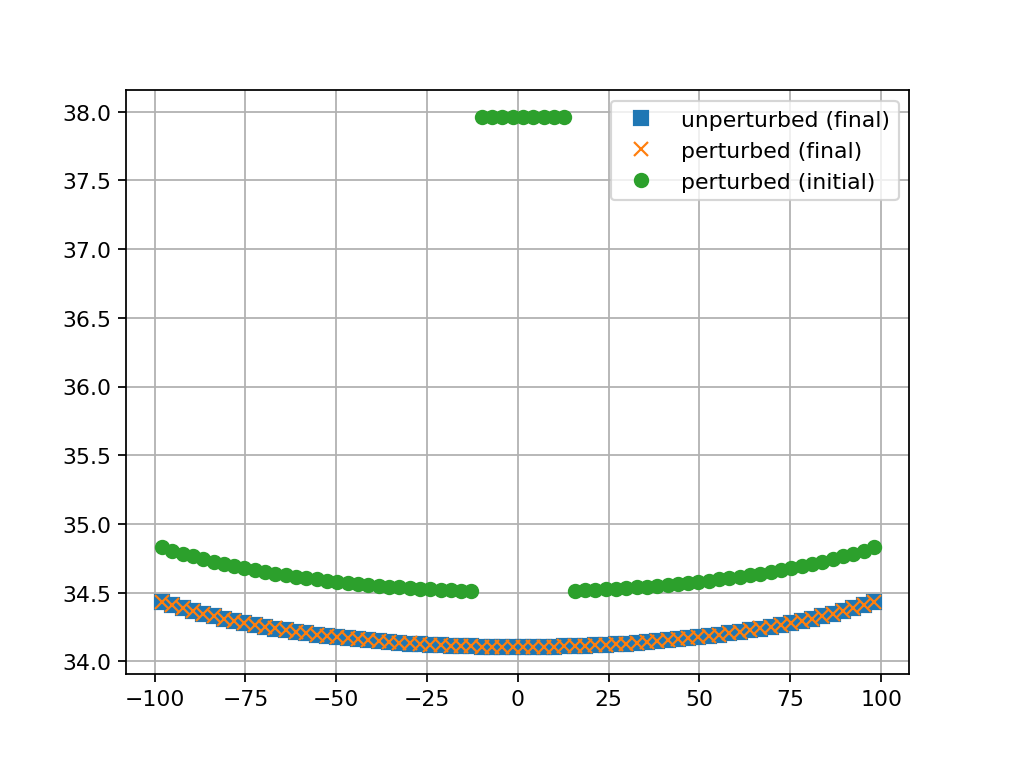

<IPython.core.display.Javascript object>


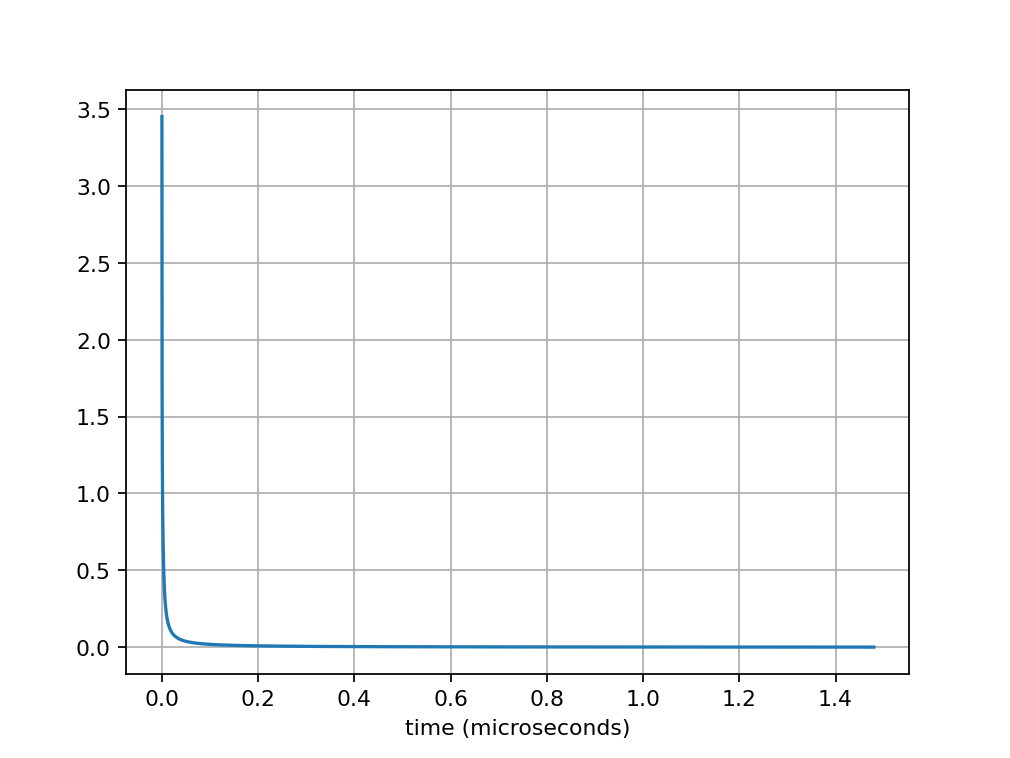

Approximate half-life = 0.00036993670969004313 microsecond


<IPython.core.display.Javascript object>


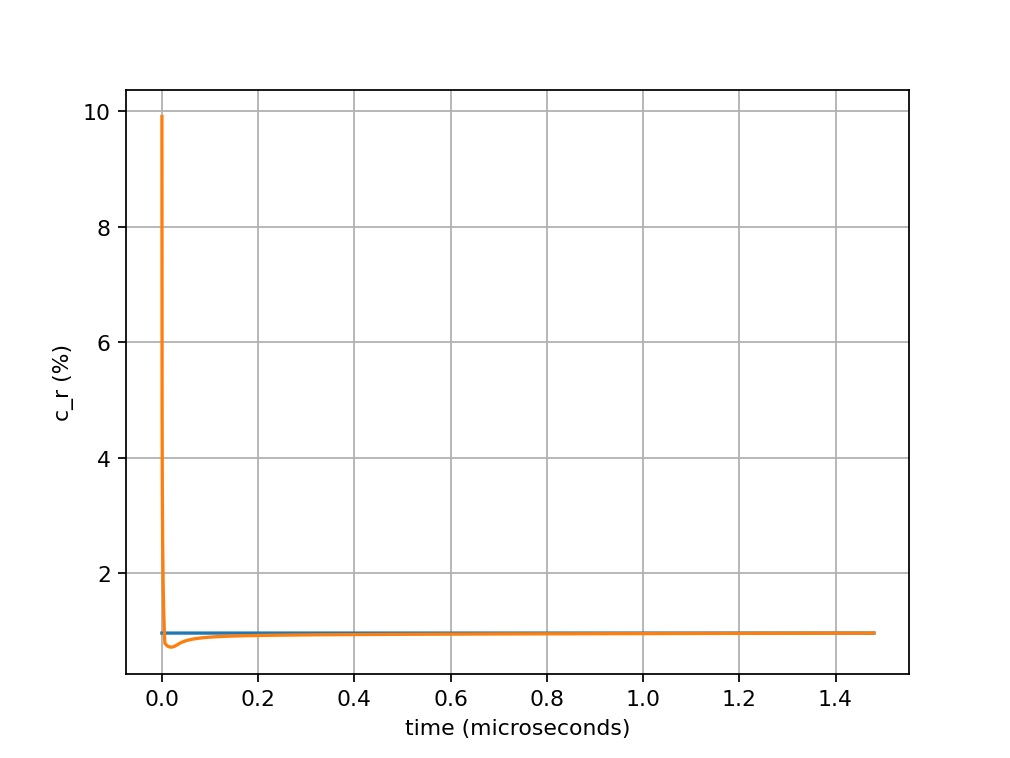

<IPython.core.display.Javascript object>


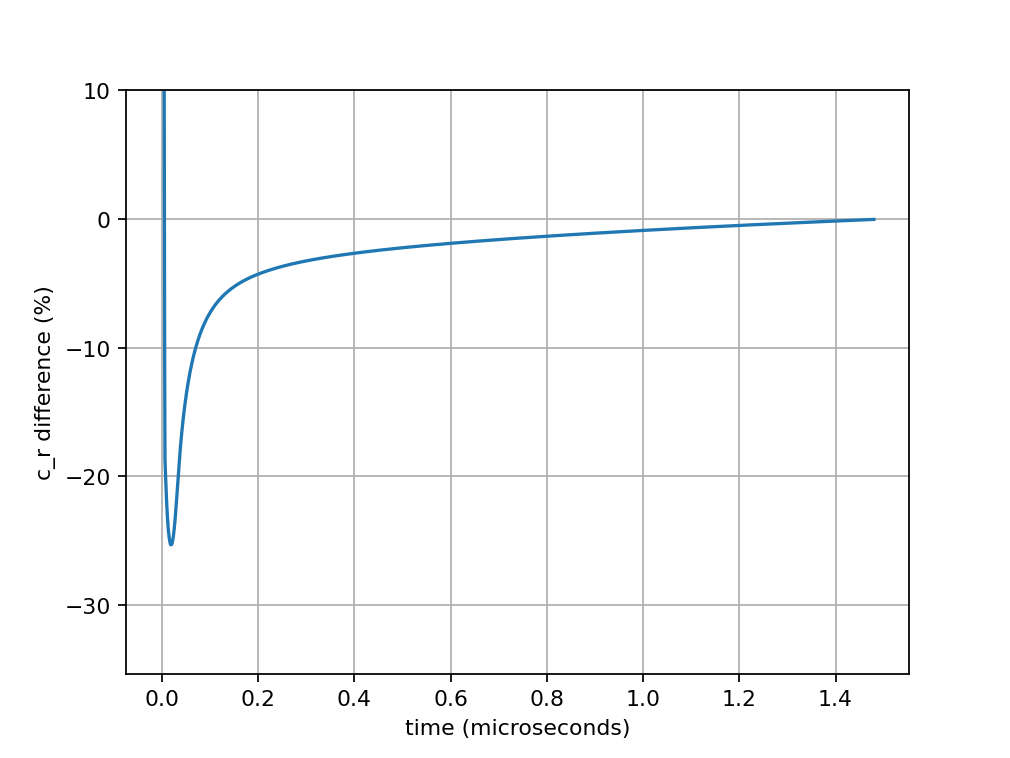

In [13]:
uslice_unperturbed_final = un_unperturbed[ixbox,nymid+boxrady]
uslice_perturbed_final = un_perturbed[ixbox,nymid+boxrady]
uslice_perturbed_initial = un_perturbed_initial[ixbox,nymid+boxrady]

plt.figure()
plt.plot(xshifted,uslice_unperturbed_final,'s',label='unperturbed (final)')
plt.plot(xshifted,uslice_perturbed_final,'x',label='perturbed (final)')
plt.plot(xshifted,uslice_perturbed_initial,'o',label='perturbed (initial)')
plt.grid(True)
plt.legend()

ukeep_perturbed_nparray = np.array(ukeep_perturbed)
ukeep_unperturbed_nparray = np.array(ukeep_unperturbed)

deltaPressure = (ukeep_perturbed_nparray-ukeep_unperturbed_nparray)
plt.figure()
plt.plot(tkeep,deltaPressure)
plt.xlabel('time (microseconds)')
plt.grid(True)
tau = tkeep[np.argmin(np.abs(deltaPressure/deltaPressure[0]-.5))]
print('Approximate half-life =',tau)

c_rx_perturbed_list_nparray = np.array(c_rx_perturbed_list)
c_rx_unperturbed_list_nparray = np.array(c_rx_unperturbed_list)
plt.figure()
plt.plot(tkeep,c_rx_unperturbed_list_nparray,label='unperturbed')
plt.plot(tkeep,c_rx_perturbed_list_nparray,label='perturbed')
plt.xlabel('time (microseconds)')
plt.ylabel('c_r (%)')
plt.grid(True)

c_rx_difference = (c_rx_perturbed_list_nparray-c_rx_unperturbed_list_nparray)/c_rx_unperturbed_list_nparray*100
plt.figure()
plt.plot(tkeep,c_rx_difference,label='relative difference')
plt.xlabel('time (microseconds)')
plt.ylabel('c_r difference (%)')
plt.ylim([np.min(c_rx_difference)-10,10])
plt.grid(True)

### Lesson of the perturbation code
The goal of the pertubation code is to see whether it's justified to ignore (as the continuum code does) the impact layer formation on a crystal surface might have on the overlying vapor field. I'm judging this by comparing two numbers. One is $\tau_{vap,pert}$, the time it takes for a spot in the vapor field to recover from a perturbation; we can get that from this vaporfield code. The other is $\tau_{res}$, the residence time a layer lingers over a given location; we can get that from the continuum model code.

It seems, from the figure above, that a perturbation in the vapor field above our growing crystal results in a fast response of $\approx -40\%$, followed by a slower recovery: it takes about $0.1 \ \mu s$ to reduce that $-40\%$ error to $-5 \%$. So we'll say $\tau_{vap,pert}\approx 0.1 \ \mu s$. $\tau_{vap,pert}$ gets bigger for bigger crystals, lower temperatures, and higher pressures.

By comparison, layer residence times in the continuum code are bigger, $\tau_{res}\approx 5 \mu s$, for similar parameters. However, $\tau_{res}$ gets smaller for bigger crystals, so the trend is right: $\tau_{res}$ gets smaller, and $\tau_{vap,pert}$ gets bigger, for large crystals. We can imagine they will meet at large enough crystal sizes. 

We've also seen from SEM experiments that $\lambda$ is even smaller, hence $\tau_{res}$ is also smaller, than the continuum code can handle. Hence we could imagine $\tau_{res}$ easily approaching $0.1 \ \mu s$. But in that case, the horizontal layer speeds needed are way too high, it seems to me. See the code below.

In [22]:
### Connecting to the continuum code ...
nmpermonolayer = AssignQuantity(0.3,'nanometer')
print('nmpermonolayer = ', nmpermonolayer)
growthrate = g_ice
print('growthrate = ', growthrate)
growthrate = g_ice/nmpermonolayer; growthrate.ito('1/second')
print('growthrate = ', growthrate)
HLS = growthrate*Lx
HLS.ito('micrometer/microsecond')
print('HLS = ', HLS)
print()

# Guessing at lambda from SEM
dz = AssignQuantity(1,'micrometer')
dx = AssignQuantity(40,'micrometer')
dzdx = dz/dx
dlayersdx = dzdx/nmpermonolayer
dlayersdx.ito('1/micrometer')
lambdabar = 1/dlayersdx
residence_time = lambdabar/HLS
print('SEM:')
print('    lambda = ', lambdabar)
print('    Residence time SEM = ', residence_time)
print()

# CM
lambdabar = AssignQuantity(3,'micrometer')
residence_time = lambdabar/HLS
print('CM:')
print('    lambda = ', lambdabar)
print('    residence_time = ', residence_time)

nmpermonolayer =  0.3 nanometer
growthrate =  2 micrometer / second
growthrate =  6666.666666666666 / second
HLS =  0.6628787878787877 micrometer / microsecond

SEM:
    lambda =  0.012 micrometer
    Residence time SEM =  0.018102857142857146 microsecond

CM:
    lambda =  3 micrometer
    residence_time =  4.525714285714287 microsecond
